# Clustering Analysis

In [326]:
%load_ext autoreload
%autoreload 2

import sys  
sys.path.insert(0, '/private/home/suching/demix-data/')
import os
import torch
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset, DataLoader
os.environ['DATA_DIR'] = "/private/home/suching/raw_data/"
DATA_DIR = os.environ['DATA_DIR']
from domain_loader.domain_loader import Domain, DomainVectorized
from cluster.cluster import Cluster
from cluster.analysis import ClusterAnalysis, domain_label_map
from transformers import pipeline
from accelerate import Accelerator
import accelerate
from accelerate import notebook_launcher
from transformers import AutoTokenizer, AutoModel
import networkx
from networkx.convert_matrix import from_numpy_matrix
from cluster.extract_features import extract_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Domains

In [39]:
label_domain_map = {y: x for x,y in domain_label_map.items()}

def read_domain(domain, files=None, sample=100):
    resolved_path = Path(DATA_DIR) / domain / domain
    if files:
        domain_files = files
    else:
        with open(Path(DATA_DIR) / domain  / "metadata" / "filenames.txt", 'r') as f:
            domain_files = []
            for x in tqdm(f.readlines()):
                fp = x.strip()
                domain_files.append(fp)

        if domain == 'reddit':
            batch_size = 1
            add_bos_token=False
        else:
            if domain != '1b':
                add_bos_token=True
            else:
                add_bos_token=False
            batch_size = 16
            sample = sample
        if sample:
            domain_files = np.random.choice(domain_files, sample)
    
    dataset = Domain(resolved_path,
                     filenames=list(domain_files),
                     add_bos_token=True, silent=True)
    dataloader = DataLoader(dataset,
                            num_workers=0,
                            batch_size=16)
    pbar = dataloader
    curr_tokens = 0
    texts = []
    metadatas = []
    for _,file, text, _, _ in pbar:
        for t in text:
            if domain == 'reddit':
                docs = t.split("<|endoftext|>")
                docs = [x for x in docs if x]
                texts.extend(docs[:sample])
                break
            else:
                texts.append(t)
        if domain == 'reddit':
            break
    
    
    df = pd.DataFrame({"text": texts,
                       'id': range(len(texts)),
                       'domain': label_domain_map[domain]})
    return df

## DEMix Data

In [59]:
domains = ['1b', 'med', 'cs', 'reviews', 'realnews', 'openwebtext', 'legal', 'reddit']


master = pd.DataFrame()
for domain in domains:
    df = read_domain(domain, sample=100)
    master = pd.concat([master, df])
master['id'] = range(len(master))
master.to_csv("demix_master.csv")

  0%|          | 0/6061 [00:00<?, ?it/s]

  0%|          | 0/3499686 [00:00<?, ?it/s]

  0%|          | 0/1117827 [00:00<?, ?it/s]

  0%|          | 0/58725733 [00:00<?, ?it/s]

  0%|          | 0/32797763 [00:04<?, ?it/s]

  0%|          | 0/8013769 [00:00<?, ?it/s]

  0%|          | 0/6830152 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

In [73]:
ids, features = torch.load('../demix_features_roberta_large.pt')
ids = ids.numpy()
features = features.numpy()

In [78]:
kmeans = Cluster("KMeans")
indices = list(master.id)
clustering = kmeans.cluster_vectors(features,
                                    indices,
                                    n_clusters=8,
                                    reduce_dimensions_first=True,
                                    num_components=50,
                                    output_dir="./")

reducing dimensions...
clustering...


ValueError: X has 768 features, but KMeans is expecting 50 features as input.

In [79]:
analysis = ClusterAnalysis(master, clustering)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3200 samples in 0.002s...
[t-SNE] Computed neighbors for 3200 samples in 0.333s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3200
[t-SNE] Computed conditional probabilities for sample 2000 / 3200
[t-SNE] Computed conditional probabilities for sample 3000 / 3200
[t-SNE] Computed conditional probabilities for sample 3200 / 3200
[t-SNE] Mean sigma: 0.541618
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.573044
[t-SNE] KL divergence after 1000 iterations: 1.608466
8


TypeError: list indices must be integers or slices, not numpy.str_

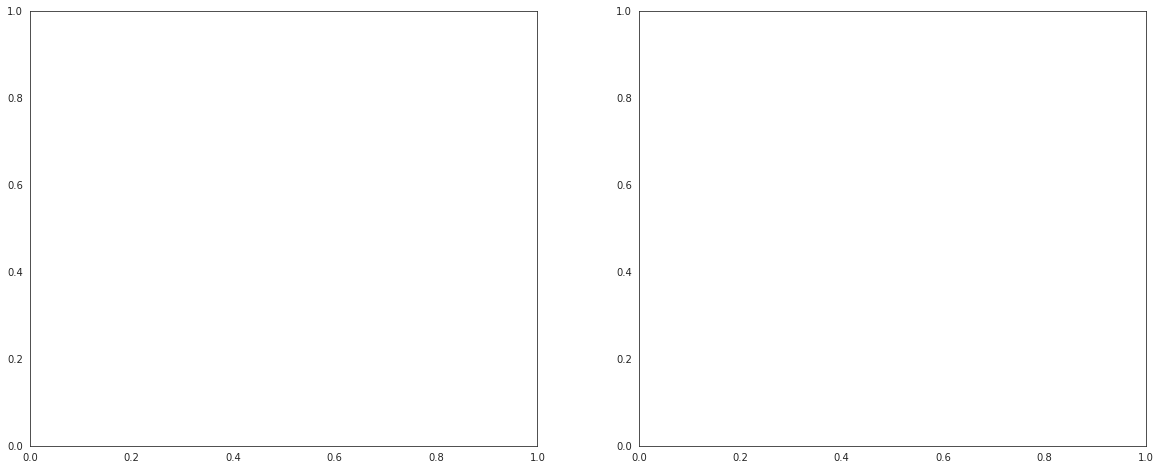

In [80]:
analysis.plot_tsne(features, ground_truth='domain')

## Openwebtext

In [58]:
df = read_domain("openwebtext", sample=3200)
df.to_csv('master.csv', sep='\t')

  0%|          | 0/8013769 [00:00<?, ?it/s]

In [88]:
df

,text,id,domain
0,<|endoftext|> Full coverage & photos here>>>\n...,0,7
1,"<|endoftext|> WASHINGTON, May 30 (Reuters) - T...",1,7
2,"<|endoftext|> ""We conducted extensive research...",2,7
3,<|endoftext|> [Major Updates]\n\nNew Rabam Ski...,3,7
4,<|endoftext|> In the first week of my undergra...,4,7
...,...,...,...
3195,<|endoftext|> 0:33 Intro. [Recording date: May...,3195,7
3196,"<|endoftext|> Answer by Jennifer 8. Lee, Wrote...",3196,7
3197,<|endoftext|> Media playback is unsupported on...,3197,7
3198,"<|endoftext|> Toto Wolff says Nico Rosberg ""di...",3198,7


In [65]:
ids, features = torch.load('../owtc_sample_feates_distilrober.pt')
ids = ids.numpy()
features = features.numpy()

In [89]:
features

array([[ 0.04123056,  0.03469923,  0.05291673, ..., -0.17449757,
         0.09021946, -0.02165925],
       [ 0.01839831,  0.12786183,  0.04034867, ..., -0.10348865,
         0.00456153, -0.00633933],
       [ 0.04558877,  0.12505421,  0.06553128, ..., -0.06216674,
         0.02678542,  0.03915891],
       ...,
       [ 0.02776264,  0.07430546,  0.09770139, ...,  0.08647031,
         0.0027823 ,  0.04514787],
       [ 0.04235045,  0.13498709,  0.03788631, ...,  0.01154242,
        -0.01970201,  0.05340825],
       [ 0.01840984,  0.10321127,  0.06823397, ..., -0.12898222,
         0.05925976, -0.01739268]], dtype=float32)

In [69]:
kmeans.predict(features.astype(float))

array([23, 23, 23, ..., 23, 23, 23], dtype=int32)

In [31]:
model = 'distilroberta-base'
# master = pd.read_csv("master.csv")
extract_features(domain="openwebtext",
                 model=model,
                 batch_size=100,
                 num_gpus=2,
                 fname=f'features_{model}_test.pt',
                 notebook=True)

Launching a training on 2 GPUs.


Exception: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/private/home/suching/.conda/envs/fairseq-20210102/lib/python3.8/site-packages/torch/multiprocessing/spawn.py", line 19, in _wrap
    fn(i, *args)
  File "/private/home/suching/.conda/envs/fairseq-20210102/lib/python3.8/site-packages/accelerate/utils.py", line 345, in __call__
    self.launcher(*args)
  File "/private/home/suching/demix-data/cluster/extract_features.py", line 80, in extract_features_
    accelerator = Accelerator()
  File "/private/home/suching/.conda/envs/fairseq-20210102/lib/python3.8/site-packages/accelerate/accelerator.py", line 112, in __init__
    self.state = AcceleratorState(fp16=fp16, cpu=cpu, deepspeed_plugin=deepspeed_plugin, _from_accelerator=True)
  File "/private/home/suching/.conda/envs/fairseq-20210102/lib/python3.8/site-packages/accelerate/state.py", line 178, in __init__
    torch.distributed.init_process_group(backend="nccl")
  File "/private/home/suching/.conda/envs/fairseq-20210102/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py", line 436, in init_process_group
    store, rank, world_size = next(rendezvous_iterator)
  File "/private/home/suching/.conda/envs/fairseq-20210102/lib/python3.8/site-packages/torch/distributed/rendezvous.py", line 179, in _env_rendezvous_handler
    store = TCPStore(master_addr, master_port, world_size, start_daemon, timeout)
RuntimeError: Address already in use


In [29]:
df = pd.read_json("/private/home/suching/raw_data/openwebtext/metadata/metadata_full_fnames.jsonl", lines=True)

KeyboardInterrupt: 

In [ ]:
tqdm.pandas()
domain_counts = df.domain.value_counts()
domains = domain_counts.loc[domain_counts > 1000].index
z = df.loc[df.domain.isin(domains)].groupby('domain').progress_apply(lambda x: x.sample(n=min(50, x.shape[0]))).reset_index(drop=True)

In [109]:
z['filename'] = z.filename.apply(lambda x: Path(DATA_DIR) / "openwebtext" / "openwebtext" / x)
texts = z.groupby('domain').progress_apply(lambda x: read_domain('openwebtext', files=x.filename.tolist()))
master = texts.drop(['domain'], axis=1).reset_index()
master['id'] = list(range(len(master)))
master.to_csv("owtc_master.csv")

  0%|          | 0/873 [00:00<?, ?it/s]

KeyError: '/private/home/suching/raw_data/openwebtext/openwebtext/urlsf_subset12-532_data/0531138-598aadb69b2b32ce3c2e97bad3289c82.txt'

In [159]:
features = torch.load('../owtc_mini.pt')


FileNotFoundError: [Errno 2] No such file or directory: '../owtc_mini.pt'

In [415]:
dataset = MMDataset( "../owtc_large_ids.npy","../owtc_large_features.npy", 8000000)
loader = DataLoader(dataset, batch_size=512)
batches = []
kmeans = MiniBatchKMeans(n_clusters=8)
for ix, batch in tqdm(loader):
    kmeans.partial_fit(batch)

  0%|          | 0/15625 [00:00<?, ?it/s]

In [278]:
import pickle
with open("kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [305]:
with open("kmeans.pkl", "rb") as f:
    kmeans = pickle.load(f)

In [163]:
features = torch.cat(batches,0)

In [309]:
from cluster.extract_features import MMDataset
from sklearn.cluster import MiniBatchKMeans

dataset = MMDataset( "../owtc_large_ids.npy","../owtc_large_features.npy")
loader = DataLoader(dataset, batch_size=512)

kmeans = MiniBatchKMeans(n_clusters=50)
# batches = []
for batch in tqdm(batches):
#     batches.append(batch)
    kmeans.partial_fit(batch)

  0%|          | 0/15625 [00:00<?, ?it/s]

tensor([-1.1088e-01, -7.0863e-02,  5.9589e-02,  7.1752e-02,  6.2611e-04,
         8.7223e-03,  2.8916e-01,  9.2934e-02,  4.6039e-01,  6.3520e-02,
        -1.0800e-01, -1.0167e-01, -4.5695e-02, -6.1976e-02,  8.7425e-02,
        -8.7146e-02,  3.0563e-01,  1.2445e-02,  4.9965e-02,  5.1490e-02,
         5.7777e-02,  7.3069e-02, -5.6480e-03,  1.9124e-01,  1.1457e-01,
         2.0027e-02, -2.5272e-02,  1.2466e-02, -1.1490e-01, -3.9483e-02,
         1.3789e-01,  1.1568e-01, -8.9275e-02,  6.4181e-02, -2.2991e-02,
        -7.3127e-02,  3.3758e-02, -5.7421e-02, -1.8639e-01, -6.6550e-02,
         1.0194e-02, -1.6393e-02,  1.6036e-02,  1.0436e-01, -6.9202e-02,
         4.9272e-02,  1.2092e-01, -5.3567e-02,  1.4848e-02,  1.1554e-02,
         1.1276e-01,  3.4376e-02,  7.1818e-02,  1.8971e-02,  3.6388e-02,
         1.6973e-02, -4.7684e-02, -3.2979e-02,  4.3158e-02, -4.1337e-02,
         6.0140e-02, -2.5686e-02,  1.2133e-01,  1.4615e-01,  9.1094e-02,
         4.4811e-02,  7.2375e-02, -4.1798e-02, -5.6

In [416]:
dataset = MMDataset( "../owtc_mini_test_ids.npy","../owtc_mini_test_features.npy", 4850)
loader = DataLoader(dataset, batch_size=512)
predictions = []
for ids, features in tqdm(loader):
    predictions.append(dict(zip(ids.tolist(), kmeans.predict(features).tolist())))

  0%|          | 0/10 [00:00<?, ?it/s]

In [417]:
predictions = {k: v for d in predictions for k, v in d.items()}

In [418]:
master = pd.read_csv("owtc_master.csv")

In [419]:
master.id

0          0
1          1
2          2
3          3
4          4
        ... 
4845    4845
4846    4846
4847    4847
4848    4848
4849    4849
Name: id, Length: 4850, dtype: int64

In [420]:
master['preds'] = master.id.apply(lambda x: predictions[x])

In [441]:
master.loc[master.preds == 7].text.sample().values

array(['<|endoftext|> If there is one thing that is to our detriment when it comes to fighting the war on terror, it’s having Barack Obama as commander-in-chief. The next worst thing I can think of would be replacing him with Mrs. Bill Clinton in November. These two are asleep at the wheel.\n\nDonald Trump has stated that Clinton is more at war with him than she is with ISIS or any other terror leader in the Middle East. ISIS has seized on the weaknesses of our president and Mrs. Clinton, neither of whom have any sense of urgency. This wait and move slowly strategy is putting American lives at risk. Like I told Sean Hannity in a recent appearance on Fox News, somebody needs to get Mrs. Bill Clinton a Red Bull, because the wolf is at the door. She failed us in Benghazi when she moved too slowly to fortify our embassy. That’s her legacy; that’s what she’s bringing to the table if she becomes president. It will be more of the same; I’ll tell you that.\n\nClinton and Obama have no clue abo

In [111]:

def get_domain_embeddings(texts, features):
    tqdm.pandas()
    def get_domain_embedding(group):
        docs = group.sample(n=min(group.shape[0], 100))
        return np.expand_dims(np.mean(features[docs.id], axis=0), axis=0)
    out = texts.groupby('domain').progress_apply(get_domain_embedding).sort_index()
    domains = out.index.values
    return domains, torch.tensor(np.concatenate(out.values, 0)).float()

def compute_cosine_similarities(domain_embeddings):
    # base similarity matrix (all dot products)
    # replace this with A.dot(A.T).toarray() for sparse representation
    similarity = np.dot(domain_embeddings, domain_embeddings.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag = np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine = similarity * inv_mag
    adjacency_matrix = cosine.T * inv_mag
    
    return adjacency_matrix

def get_neighbors(graph, domain: str, min_threshold=0.0):
    """
    Get neighbors of a subreddit with similarity above min_threshold.
    """
    list_neighbors = networkx.neighbors(graph, domain)
    res = []
    for i in list_neighbors:
            if graph.edges[(domain,i)]['weight'] > min_threshold:
                res.append({"domain": i, **graph.edges[(domain,i)]})
    return pd.DataFrame(res)
    



In [112]:
domains, domain_embeddings = get_domain_embeddings(master, features)
adjacency_matrix = compute_cosine_similarities(domain_embeddings)
print("building graph...")
graph = from_numpy_matrix(adjacency_matrix, create_using=networkx.Graph)
graph = networkx.relabel_nodes(graph, {x: y for x,y in enumerate(domains)})

  0%|          | 0/10655 [00:00<?, ?it/s]

building graph...


In [114]:
get_neighbors(graph, 'pcgamer.com', min_threshold=0.0).sort_values(by='weight',ascending=False)

,domain,weight
6708,pcgamer.com,1.000000
9520,totalxbox.com,0.999481
3534,gameranx.com,0.999393
6711,pcinvasion.com,0.999344
1934,computerandvideogames.com,0.999250
...,...,...
5931,n1info.com,0.946422
4396,index.hr,0.944650
4408,indiaspend.com,0.943041
8116,snob.ru,0.935050


In [115]:
get_neighbors(graph, 'nih.gov', min_threshold=0.0).sort_values(by='weight',ascending=False)

,domain,weight
6233,nih.gov,1.000000
6084,neurology.org,0.997569
8573,tandfonline.com,0.997527
5503,mdpi.com,0.997451
7774,sciencedirect.com,0.996749
...,...,...
596,ashes2asheslegacy.wordpress.com,0.938653
2442,detgodasamhallet.com,0.938252
4408,indiaspend.com,0.938181
8192,southparkstudios.com,0.936566


## Scaling up on OWTC

In [96]:
ids, features = torch.load('../owtc_large_features_distilroberta.pt')
ids = ids.numpy()
features = features.numpy()
domains, domain_embeddings = get_domain_embeddings(master, features)
adjacency_matrix = compute_cosine_similarities(domain_embeddings)
print("building graph...")
graph = from_numpy_matrix(adjacency_matrix, create_using=networkx.Graph)
graph = networkx.relabel_nodes(graph, {x: y for x,y in enumerate(domains)})

  0%|          | 0/97 [00:00<?, ?it/s]

building graph...


In [101]:
get_neighbors(graph, 'cnn.com', min_threshold=0.0).sort_values(by='weight',ascending=False)

,domain,weight
17,cnn.com,1.000000
10,buzzfeed.com,0.999114
22,dailymail.co.uk,0.999076
91,washingtonpost.com,0.999068
25,espn.com,0.999026
...,...,...
34,independent.co.uk,0.978864
93,wikia.com,0.978273
77,thedailybeast.com,0.978111
36,indiatimes.com,0.972963


In [44]:


# master = texts.sample(n=10000)
# master.to_csv("master.csv")
master = pd.read_csv("master.csv")
master['id'] = list(range(len(master)))
model = 'distilroberta-base'
extract_features(texts=master,
                 model=model,
                 batch_size=100,
                num_gpus=2,
                 fname=f'features_{model}_test.pt',
                notebook=True)

ids, features = torch.load('features_distilroberta.pt')


KeyboardInterrupt: 

In [50]:
ids, features = torch.load('../features_test.pt')
ids = ids.numpy()
features = features.numpy()

In [12]:

def get_domain_embeddings(texts, features):
    tqdm.pandas()
    def get_domain_embedding(group):
        docs = group.sample(n=min(group.shape[0], 100))
        return np.expand_dims(np.mean(features[docs.id], axis=0), axis=0)
    out = texts.groupby('domain').progress_apply(get_domain_embedding).sort_index()
    domains = out.index.values
    return domains, torch.tensor(np.concatenate(out.values, 0)).float()

def compute_cosine_similarities(domain_embeddings):
    # base similarity matrix (all dot products)
    # replace this with A.dot(A.T).toarray() for sparse representation
    similarity = np.dot(domain_embeddings, domain_embeddings.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag = np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine = similarity * inv_mag
    adjacency_matrix = cosine.T * inv_mag
    
    return adjacency_matrix

def get_neighbors(graph, domain: str, min_threshold=0.0):
    """
    Get neighbors of a subreddit with similarity above min_threshold.
    """
    list_neighbors = networkx.neighbors(graph, domain)
    res = []
    for i in list_neighbors:
            if graph.edges[(domain,i)]['weight'] > min_threshold:
                res.append({"domain": i, **graph.edges[(domain,i)]})
    return pd.DataFrame(res)
    



In [52]:
domains, domain_embeddings = get_domain_embeddings(master, features)
adjacency_matrix = compute_cosine_similarities(domain_embeddings)
print("building graph...")
graph = from_numpy_matrix(adjacency_matrix, create_using=networkx.Graph)
graph = networkx.relabel_nodes(graph, {x: y for x,y in enumerate(domains)})

  0%|          | 0/10655 [00:00<?, ?it/s]

building graph...


KeyboardInterrupt: 

In [ ]:
import pickle
with open('graph.pkl', 'wb+') as f:
    pickle.dump(graph, f)

In [39]:
get_neighbors(graph, 'thehindu.com', min_threshold=0.0).sort_values(by='weight',ascending=False)

,domain,weight
8993,thehindu.com,1.000000
7823,scroll.in,0.999289
9187,theprint.in,0.999165
6155,newsgram.com,0.999164
9679,twocircles.net,0.999118
...,...,...
7383,redditgifts.com,0.943587
9367,thisishell.com,0.943004
3598,gdcvault.com,0.942811
4207,hottopic.com,0.939047


In [69]:
analysis = ClusterAnalysis(master, clustering)

reducing dimensions...
clustering...


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.001s...
[t-SNE] Computed neighbors for 800 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.502487
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.309212
[t-SNE] KL divergence after 1000 iterations: 0.642915
8


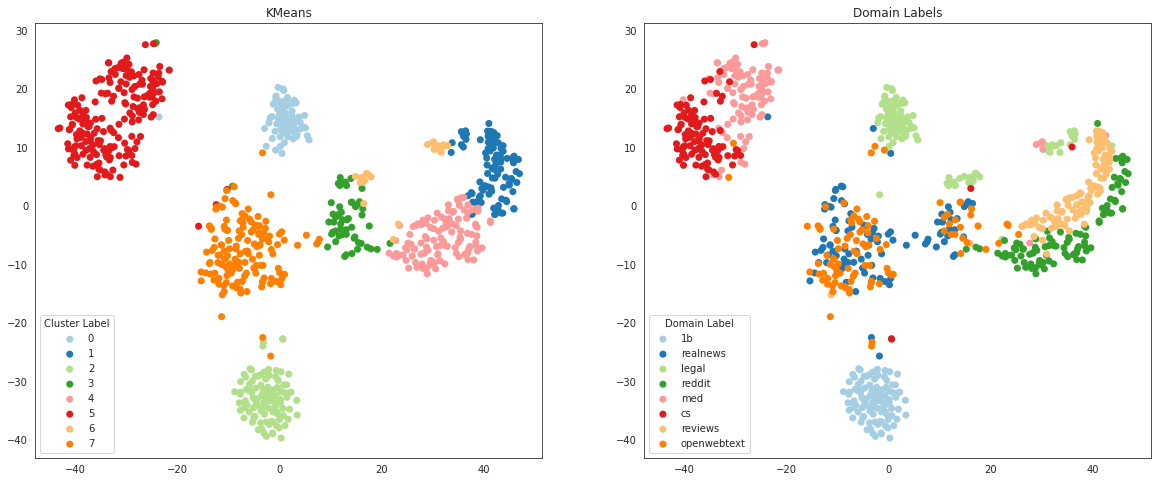

In [72]:

# master['domain'].value_counts()

In [64]:
analysis.get_cross_documents('domain', 'legal',0)

,domain,level_1,text,id,metadata


In [61]:
results = analysis.cluster_label_distributions(label='domain')

  0%|          | 0/5 [00:00<?, ?it/s]

KeyError: 'heavy.com'

In [ ]:
results[domains]

<AxesSubplot:>

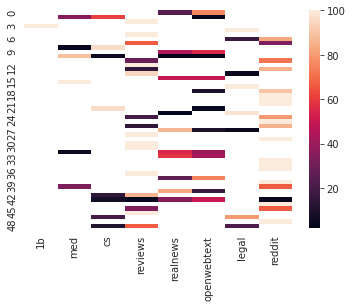

In [331]:
import seaborn as sns
sns.heatmap(results[domains])

In [332]:
analysis.get_cross_documents("domain", "cs", 1).text.shape

(19,)

In [350]:
df = read_domain("openwebtext", sample=100)
feats = extract_features(df.text.tolist(), 32)

  0%|          | 0/8013769 [00:00<?, ?it/s]

loaded 100 files, ignoring 0 files


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [351]:
reduced_feats = clustering['pca'].transform(feats)
predicted_clusters = clustering['model'].predict(reduced_feats)
pd.Series(predicted_clusters).value_counts()

43    21
9     15
38    15
0     14
32    12
27    10
41     5
15     3
33     2
10     1
22     1
46     1
dtype: int64

In [352]:
df.loc[predicted_clusters == 3].text.values

array([], dtype=object)